In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('pharma.csv', index_col=['date'])
prices.head(10)

SUNPHARMA.NS   DRREDDY.NS  DIVISLAB.NS    CIPLA.NS    LUPIN.NS  \
date                                                                         
01-01-2018    574.049988  2404.149902  1099.050049  611.500000  883.250000   
02-01-2018    572.150024  2409.199951  1080.900024  607.799988  875.150024   
03-01-2018    569.049988  2339.000000  1099.400024  606.799988  878.950012   
04-01-2018    581.200012  2410.800049  1106.550049  616.750000  878.150024   
05-01-2018    578.750000  2473.399902  1107.650024  615.150024  900.150024   
08-01-2018    591.599976  2476.600098  1116.199951  615.049988  923.299988   
09-01-2018    586.500000  2457.800049  1089.300049  615.599976  923.250000   
10-01-2018    585.099976  2425.800049  1079.300049  619.750000  925.799988   
11-01-2018    587.950012  2425.350098  1101.550049  612.349976  929.200012   
12-01-2018    583.450012  2447.649902  1093.800049  612.099976  919.099976   

            LAURUSLABS.NS  AUROPHARMA.NS   BIOCON.NS     ALKEM.NS  
date                                                               
01-01-2018     107.919998     683.950012  269.000000  2225.949951  
02-01-2018     107.190002     671.400024  270.850006  2200.100098  
03-01-2018     107.370003     665.549988  270.924988  2213.050049  
04-01-2018     108.830002     668.299988  270.825012  2217.050049  
05-01-2018     110.290001     671.150024  270.475006  2220.300049  
08-01-2018     112.199997     677.349976  277.674988  2218.000000  
09-01-2018     110.699997     673.150024  272.750000  2222.100098  
10-01-2018     108.639999     672.700012  270.924988  2323.600098  
11-01-2018     110.050003     674.549988  273.125000  2287.250000  
12-01-2018     109.230003     667.049988  270.200012  2258.850098

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

SUNPHARMA.NS   DRREDDY.NS  DIVISLAB.NS    CIPLA.NS    LUPIN.NS  \
date                                                                         
01-01-2018    574.049988  2404.149902  1099.050049  611.500000  883.250000   
02-01-2018    572.150024  2409.199951  1080.900024  607.799988  875.150024   
30-12-2020    584.000000  5170.950195  3799.699951  823.799988  977.599976   
31-12-2020    592.349976  5205.100098  3841.899902  819.950012  976.849976   

            LAURUSLABS.NS  AUROPHARMA.NS   BIOCON.NS     ALKEM.NS  
date                                                               
01-01-2018     107.919998     683.950012  269.000000  2225.949951  
02-01-2018     107.190002     671.400024  270.850006  2200.100098  
30-12-2020     350.049988     906.750000  458.700012  2928.449951  
31-12-2020     353.149994     921.299988  465.399994  2926.199951

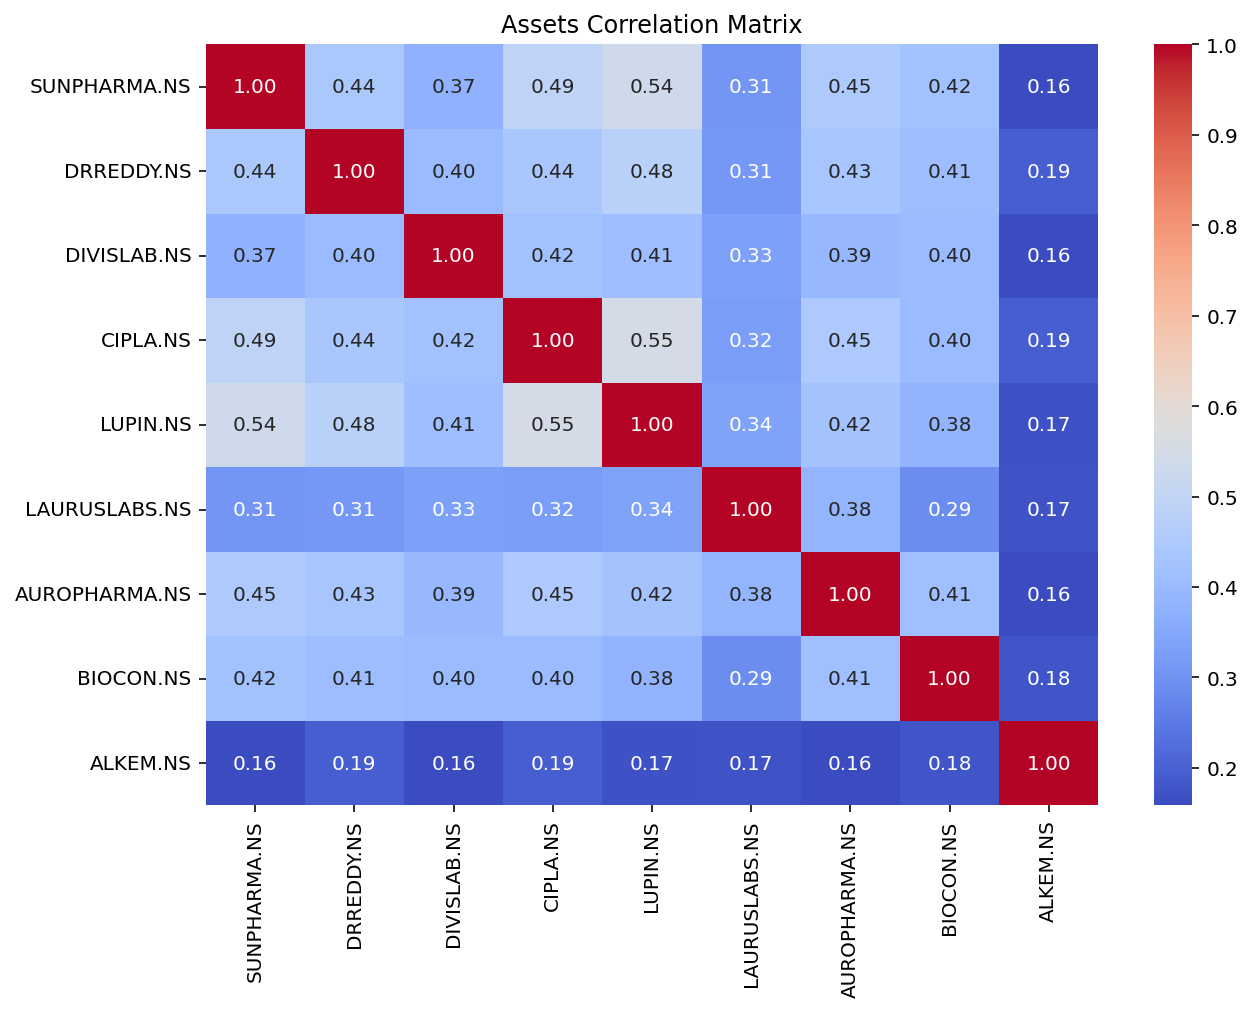

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DRREDDY.NS', 'DIVISLAB.NS'), ('LUPIN.NS', 'BIOCON.NS')]


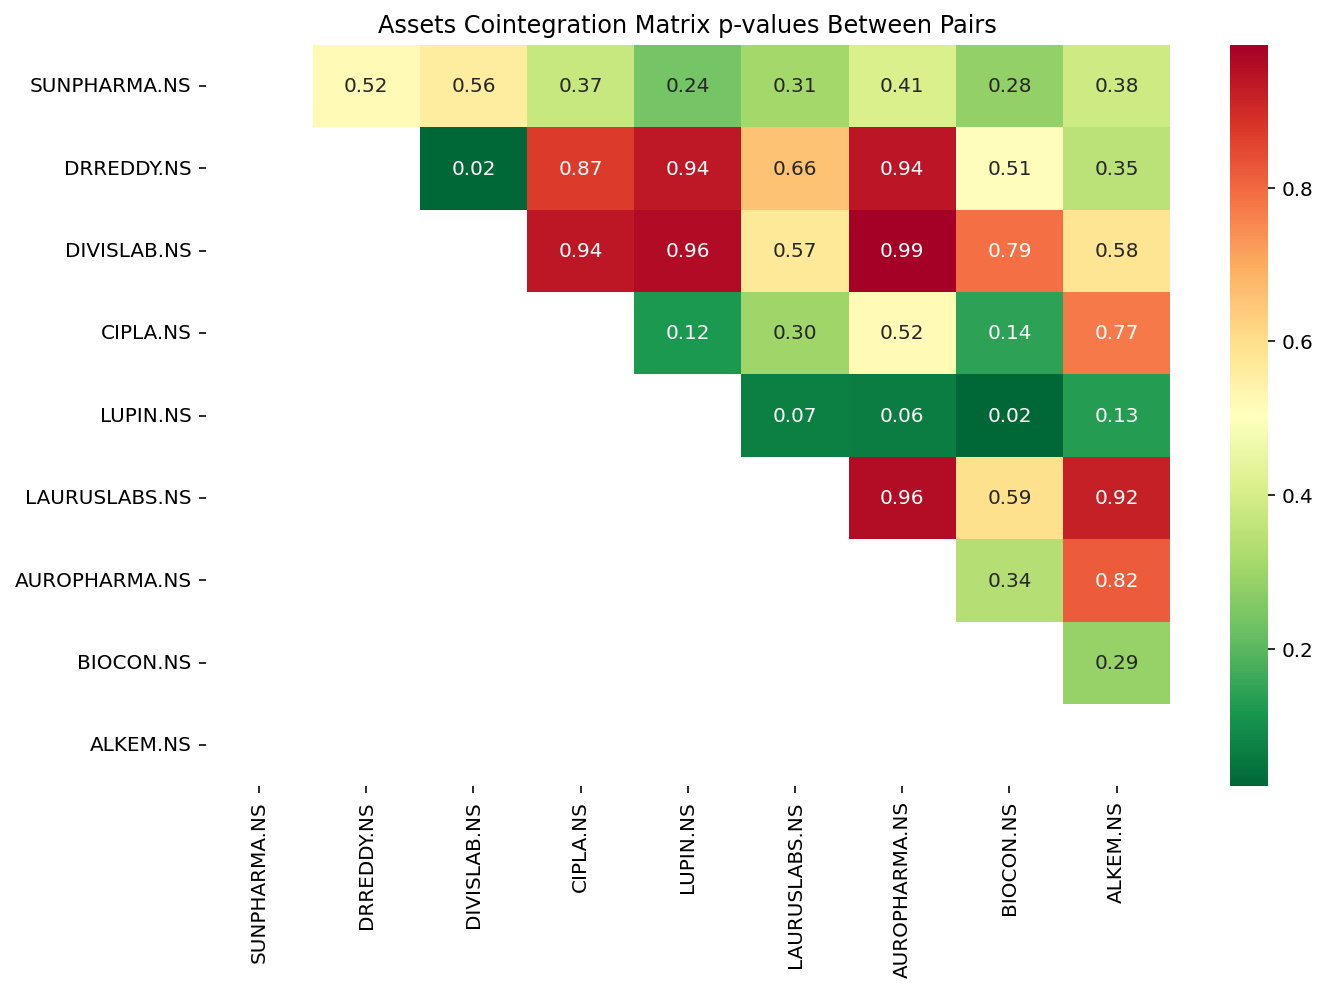

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'DRREDDY.NS'
asset2 = 'DIVISLAB.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

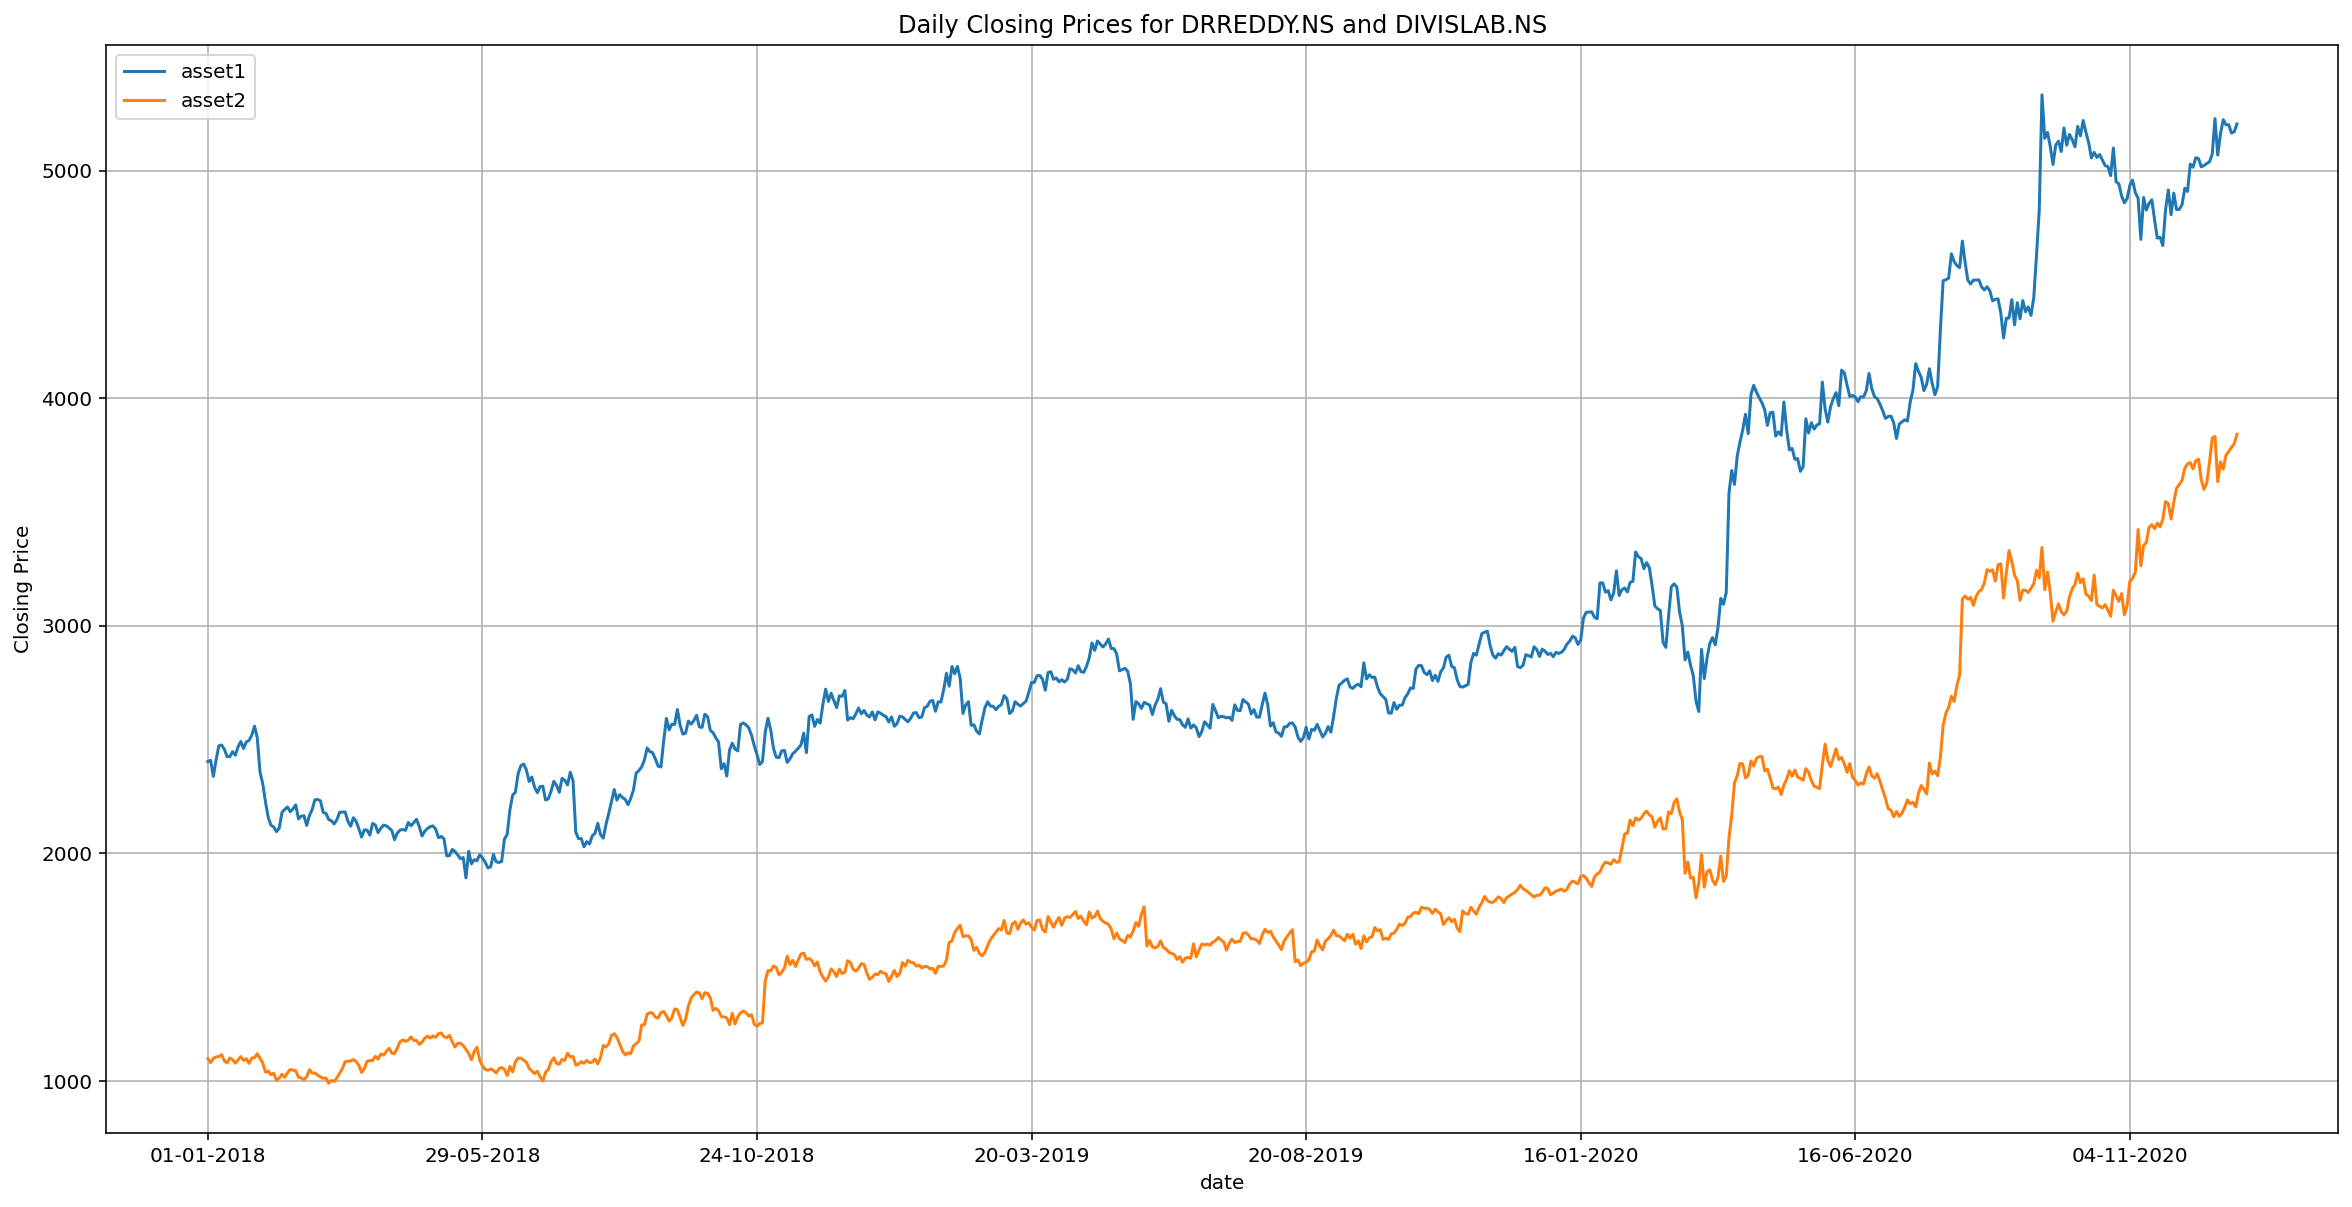

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          5.691e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        17:30:02   Log-Likelihood:                         -5052.1
No. Observations:                 740   AIC:                                  1.011e+04
Df Residuals:                     739   BIC:                                  1.011e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.6172      0.003    238.550      0.000       0.612       0.622
==============================================================================
Omnibus:                      129.448   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.041
Skew:                           1.081   Prob(JB):                     1.66e-48
Kurtosis:                       4.570   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

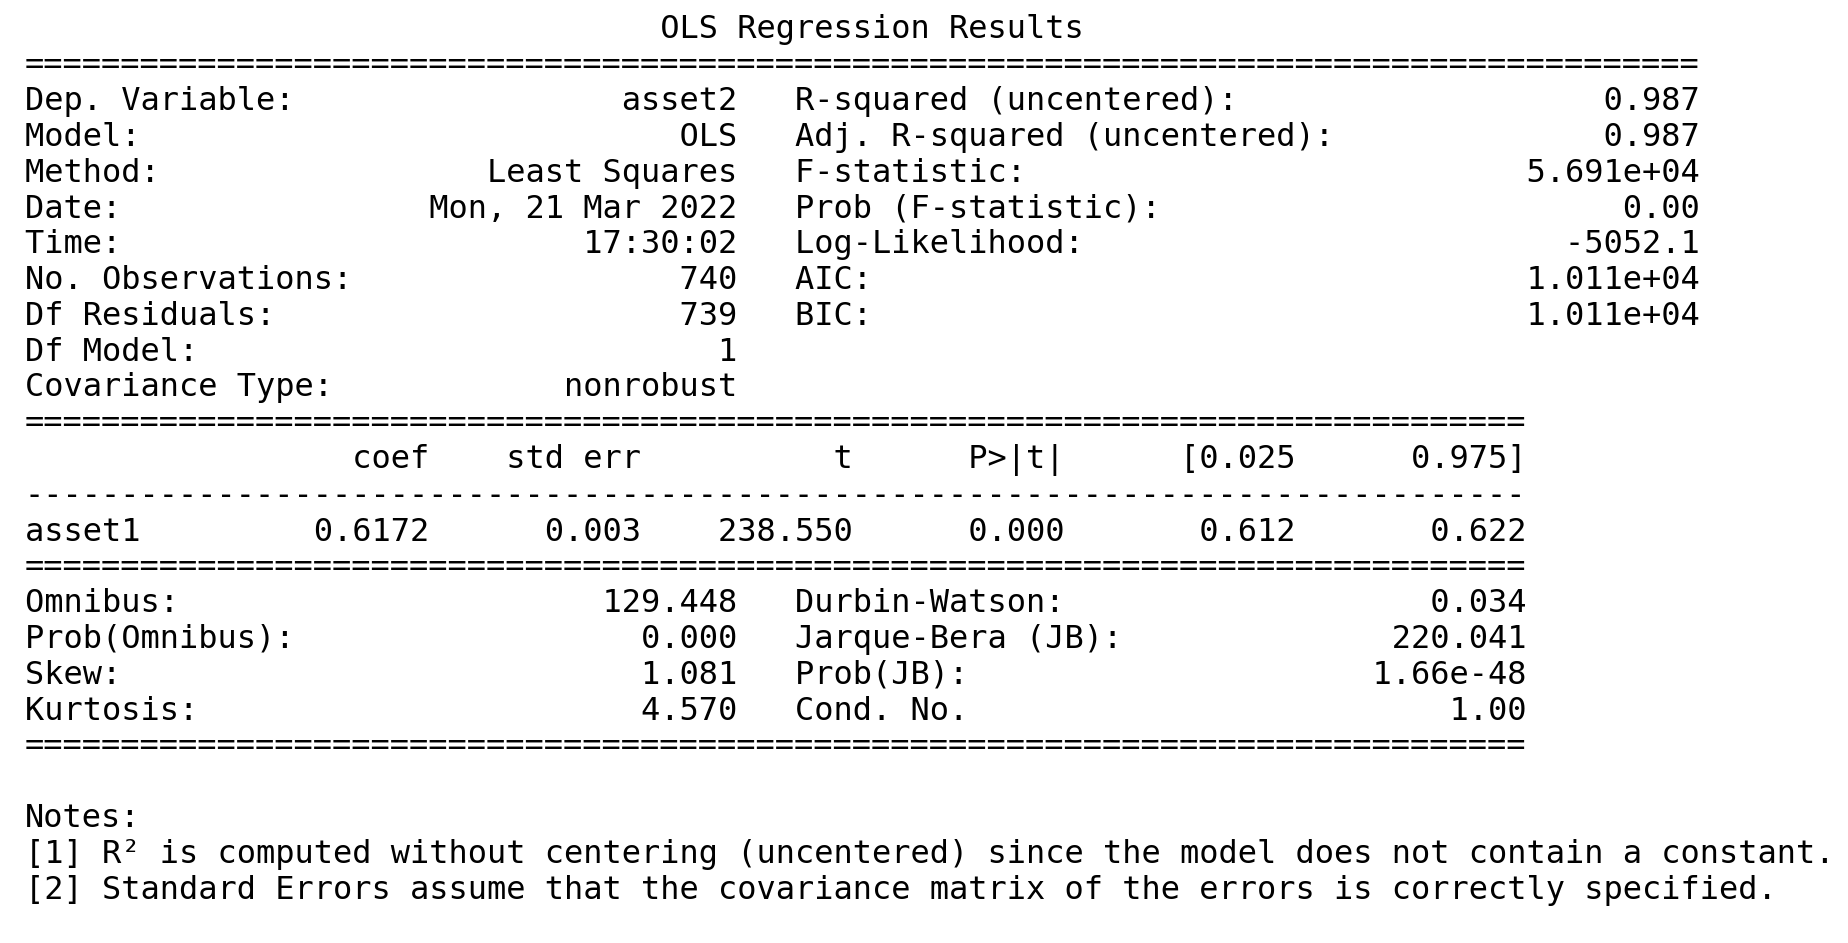

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.6172111172708901


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

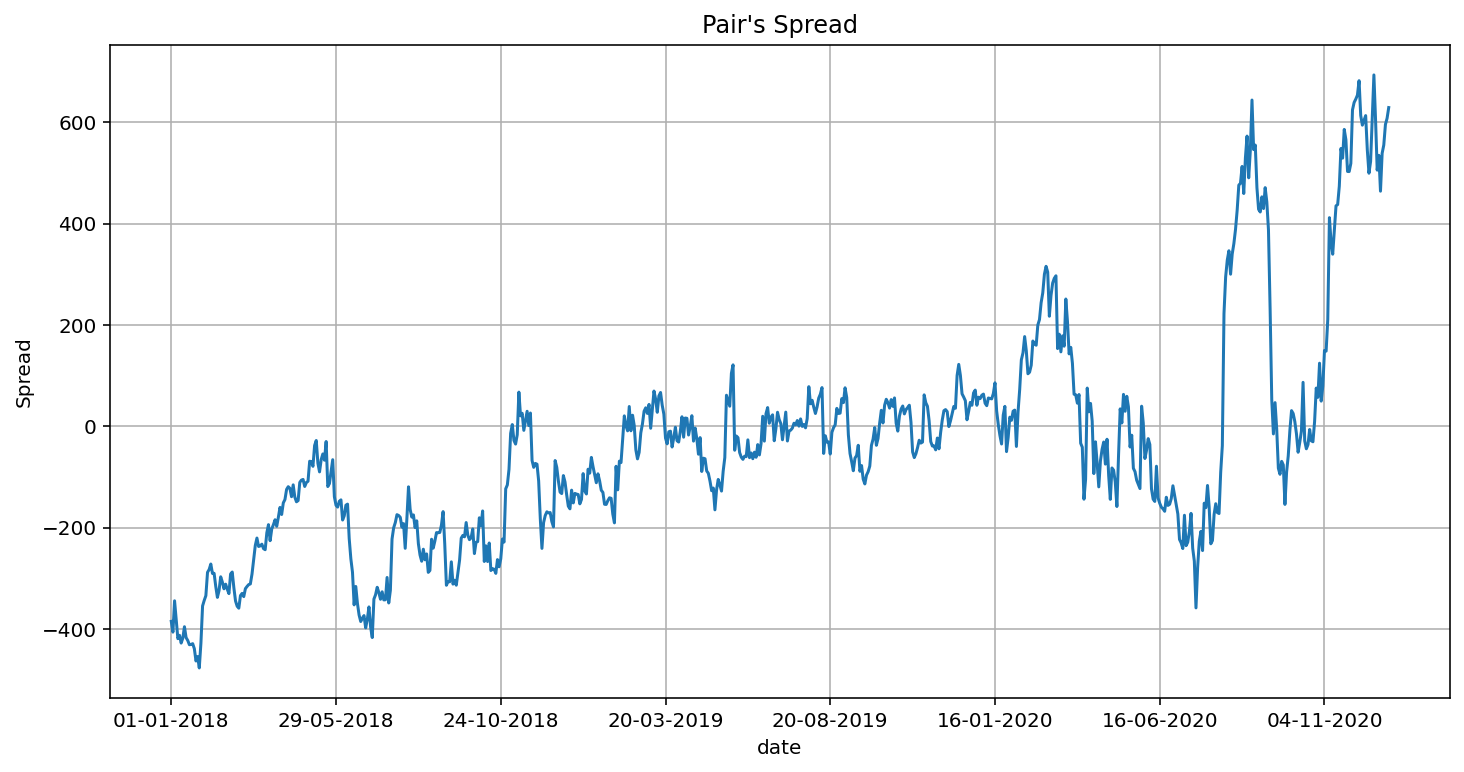

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-1.910996113070757,
 0.32690600539531406,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 7590.672032288097)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -1.910996113070757


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1       asset2
date                                
01-01-2021  5241.350098  3849.050049
04-01-2021  5272.250000  3862.250000
05-01-2021  5286.899902  3842.100098
06-01-2021  5288.299805  3879.850098
07-01-2021  5270.899902  3803.050049

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1       asset2         z  z upper limit  z lower limit
date                                                                        
01-01-2021  5241.350098  3849.050049  1.315433            1.0           -1.0
04-01-2021  5272.250000  3862.250000  1.335578            1.0           -1.0
05-01-2021  5286.899902  3842.100098  1.401627            1.0           -1.0
06-01-2021  5288.299805  3879.850098  1.323204            1.0           -1.0
07-01-2021  5270.899902  3803.050049  1.461356            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

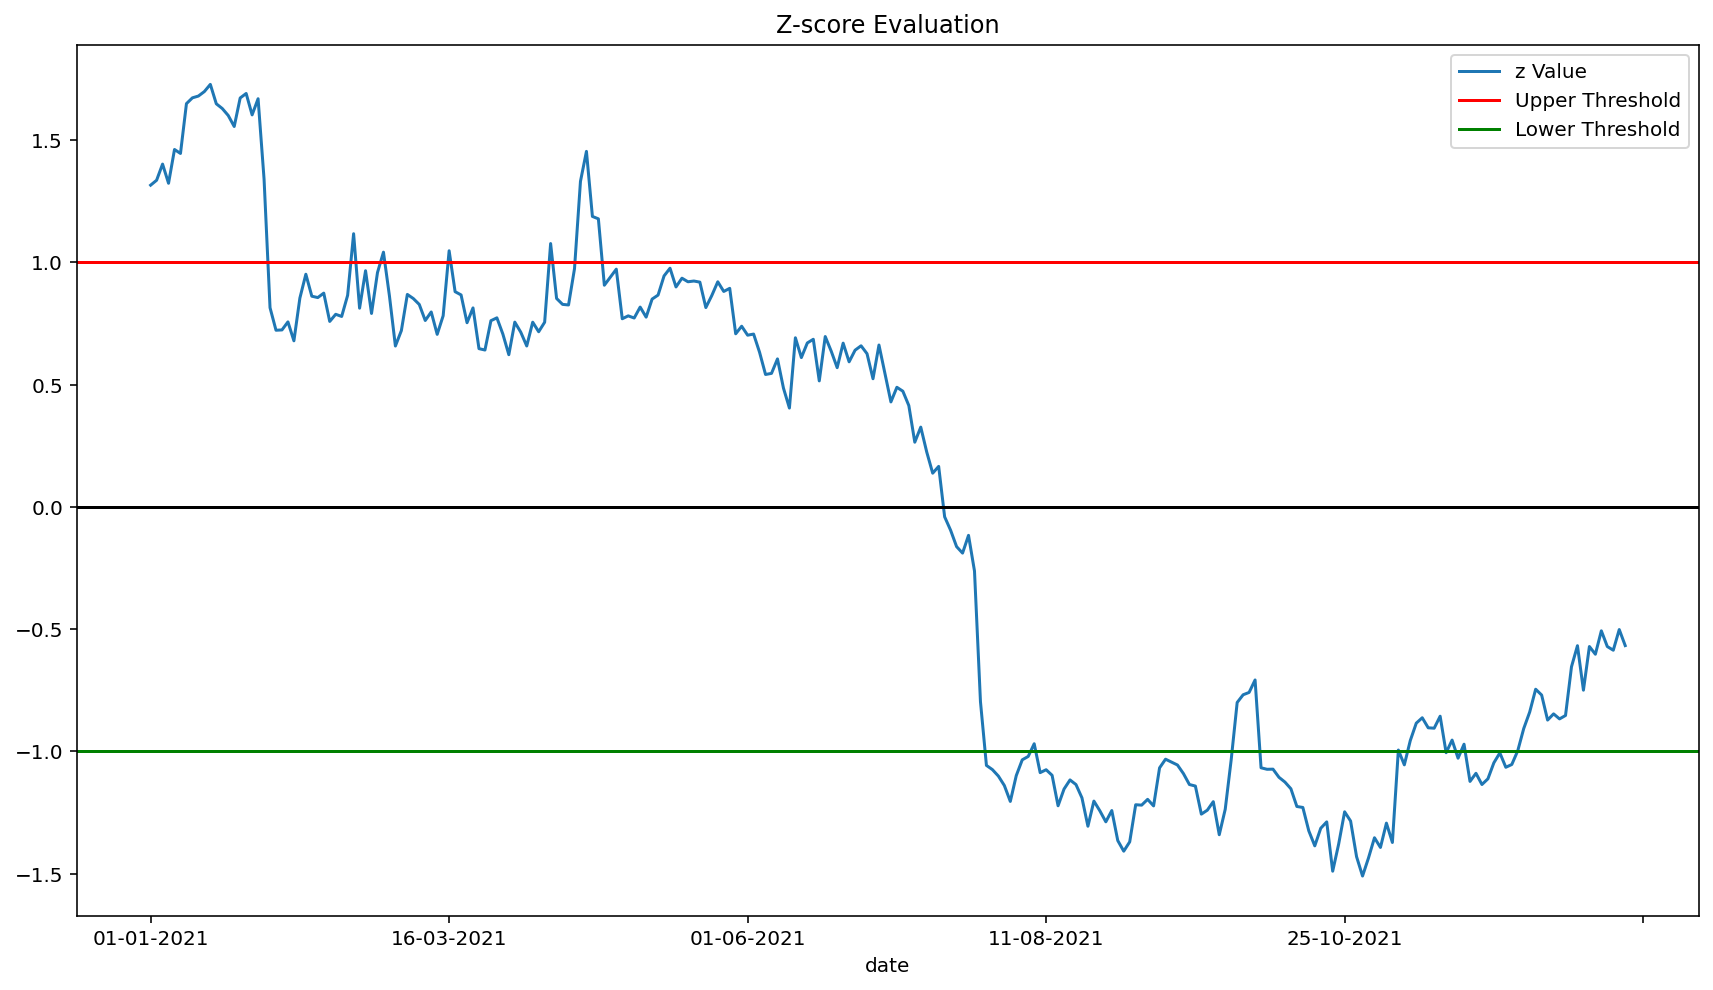

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  5241.350098  3849.050049  1.315433            1.0           -1.0   
04-01-2021  5272.250000  3862.250000  1.335578            1.0           -1.0   
05-01-2021  5286.899902  3842.100098  1.401627            1.0           -1.0   
29-12-2021  4833.149902  4621.600098 -0.586504            1.0           -1.0   
30-12-2021  4904.700195  4627.899902 -0.502005            1.0           -1.0   
31-12-2021  4907.000000  4678.200195 -0.567642            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  5241.350098  3849.050049  1.315433            1.0           -1.0   
04-01-2021  5272.250000  3862.250000  1.335578            1.0           -1.0   
05-01-2021  5286.899902  3842.100098  1.401627            1.0           -1.0   
06-01-2021  5288.299805  3879.850098  1.323204            1.0           -1.0   
07-01-2021  5270.899902  3803.050049  1.461356            1.0           -1.0   
08-01-2021  5338.250000  3859.149902  1.445130            1.0           -1.0   
11-01-2021  5416.799805  3822.399902  1.648892            1.0           -1.0   
12-01-2021  5353.850098  3767.500000  1.672619            1.0           -1.0   
13-01-2021  5290.000000  3719.399902  1.679907            1.0           -1.0   
14-01-2021  5308.899902  3724.699951  1.698270            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
08-01-2021        -1         0.0         1         0.0  
11-01-2021        -1         0.0         1         0.0  
12-01-2021        -1         0.0         1         0.0  
13-01-2021        -1         0.0         1         0.0  
14-01-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  5241.350098  3849.050049  1.315433            1.0           -1.0   
01-02-2021  4428.149902  3463.600098  0.814329            1.0           -1.0   
19-02-2021  4681.450195  3523.199951  1.116926            1.0           -1.0   
22-02-2021  4469.250000  3496.649902  0.812343            1.0           -1.0   
26-02-2021  4426.549805  3363.100098  1.041449            1.0           -1.0   
22-11-2021  4607.600098  4679.149902 -0.954100            1.0           -1.0   
23-11-2021  4631.950195  4763.299805 -1.028047            1.0           -1.0   
24-11-2021  4598.049805  4682.700195 -0.970871            1.0           -1.0   
25-11-2021  4591.600098  4799.799805 -1.123167            1.0           -1.0   
07-12-2021  4520.700195  4624.799805 -0.997549            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
01-02-2021         0         1.0         0        -1.0  
19-02-2021        -1        -1.0         1         1.0  
22-02-2021         0         1.0         0        -1.0  
26-02-2021        -1        -1.0         1         1.0  
22-11-2021         0        -1.0         0         1.0  
23-11-2021         1         1.0        -1        -1.0  
24-11-2021         0        -1.0         0         1.0  
25-11-2021         1         1.0        -1        -1.0  
07-12-2021         0        -1.0         0         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

4428.149902    1
4469.250000    1
4453.399902    1
4355.850098    1
4777.299805    1
5057.250000    1
4731.750000    1
4769.750000    1
5042.700195    1
4792.350098    1
4671.450195    1
4631.950195    1
4591.600098    1
Name: asset1, dtype: int64

In [32]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  5241.350098  3849.050049  1.315433            1.0           -1.0   
04-01-2021  5272.250000  3862.250000  1.335578            1.0           -1.0   
05-01-2021  5286.899902  3842.100098  1.401627            1.0           -1.0   
06-01-2021  5288.299805  3879.850098  1.323204            1.0           -1.0   
07-01-2021  5270.899902  3803.050049  1.461356            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  4736.899902  4473.200195 -0.507183            1.0           -1.0   
28-12-2021  4743.799805  4525.350098 -0.571465            1.0           -1.0   
29-12-2021  4833.149902  4621.600098 -0.586504            1.0           -1.0   
30-12-2021  4904.700195  4627.899902 -0.502005            1.0           -1.0   
31-12-2021  4907.000000  4678.200195 -0.567642            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

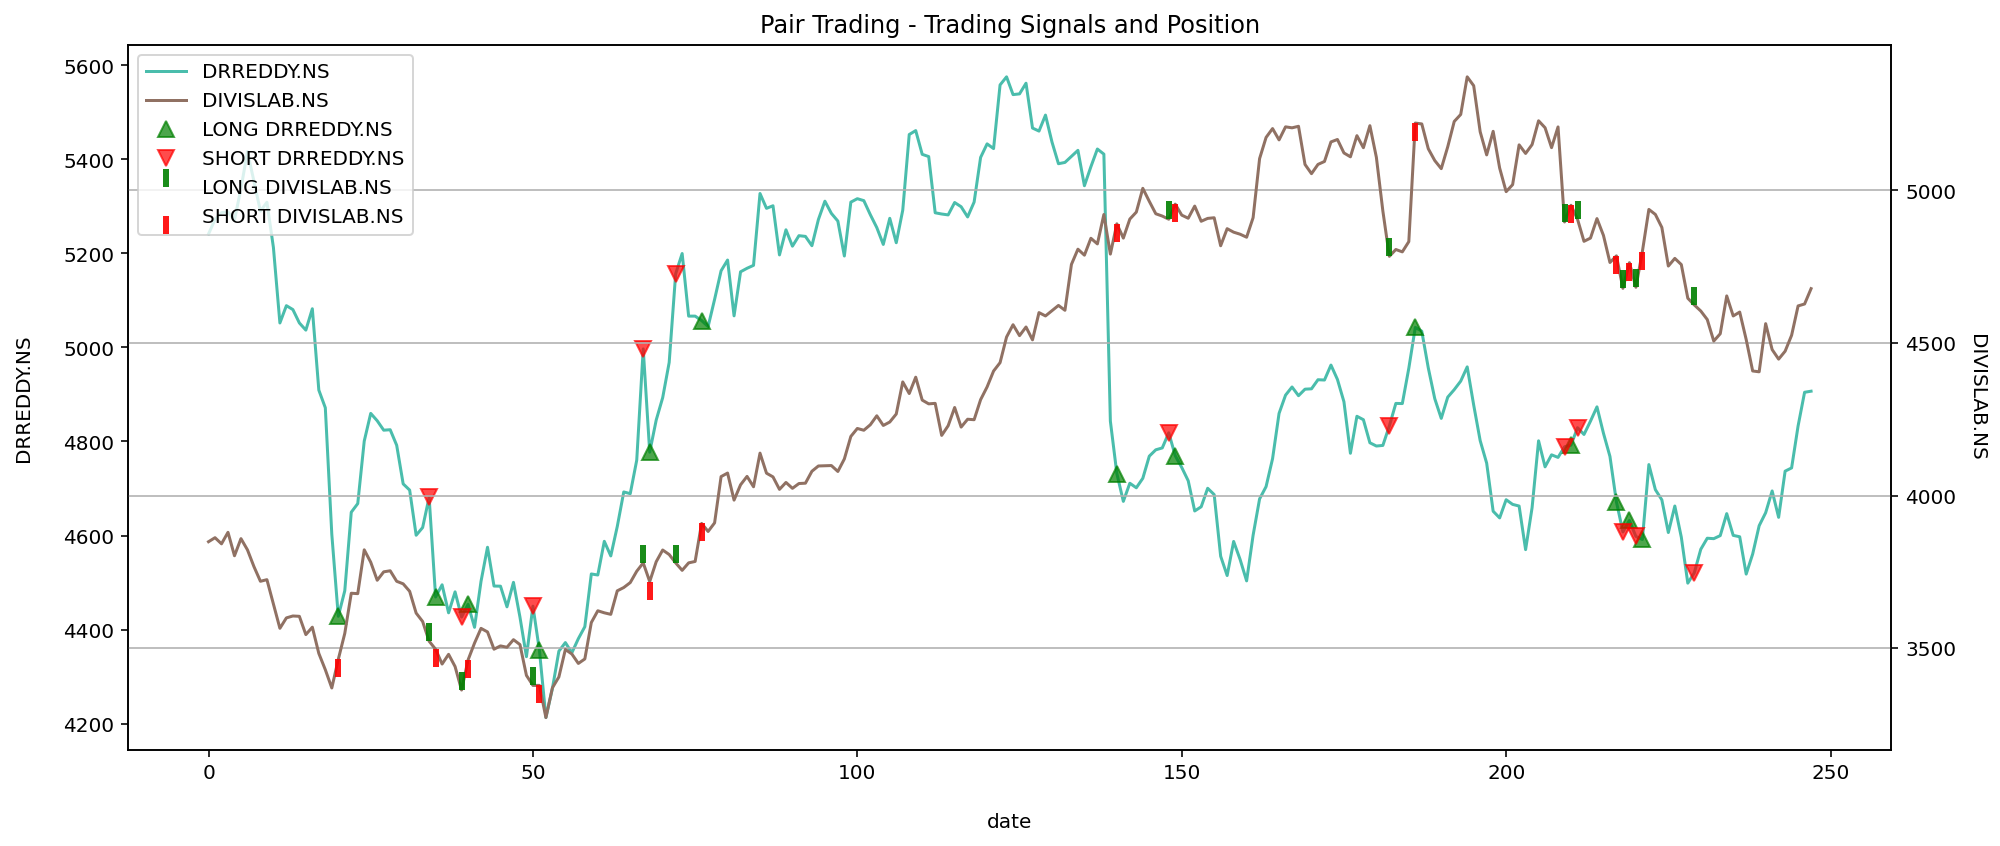

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1      cash1   total asset1   return1  positions1
0    5241.350098           NaN        NaN            NaN       NaN         NaN
1    5272.250000      0.000000  100000.00  100000.000000       NaN         0.0
2    5286.899902      0.000000  100000.00  100000.000000  0.000000         0.0
3    5288.299805      0.000000  100000.00  100000.000000  0.000000         0.0
4    5270.899902      0.000000  100000.00  100000.000000  0.000000         0.0
243  4736.899902  80527.298334   30890.75  111418.048334  0.015219         0.0
244  4743.799805  80644.596685   30890.75  111535.346685  0.001053         0.0
245  4833.149902  82163.548334   30890.75  113054.298334  0.013619         0.0
246  4904.700195  83379.903315   30890.75  114270.653315  0.010759         0.0
247  4907.000000  83419.000000   30890.75  114309.750000  0.000342         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   5241.350098           NaN            NaN            NaN       NaN   
20  4428.149902  75278.548334   24721.451666  100000.000000  0.000000   
34  4681.450195      0.000000  104306.104981  104306.104981  0.010624   
35  4469.250000  75977.250000   28328.854981  104306.104981  0.000000   
39  4426.549805      0.000000  103580.201666  103580.201666 -0.008720   

    positions1  
0          NaN  
20         1.0  
34        -1.0  
35         1.0  
39        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1      cash1   total asset1   return1  \
0    5241.350098           NaN        NaN            NaN       NaN   
1    5272.250000      0.000000  100000.00  100000.000000       NaN   
2    5286.899902      0.000000  100000.00  100000.000000  0.000000   
3    5288.299805      0.000000  100000.00  100000.000000  0.000000   
4    5270.899902      0.000000  100000.00  100000.000000  0.000000   
243  4736.899902  80527.298334   30890.75  111418.048334  0.015219   
244  4743.799805  80644.596685   30890.75  111535.346685  0.001053   
245  4833.149902  82163.548334   30890.75  113054.298334  0.013619   
246  4904.700195  83379.903315   30890.75  114270.653315  0.010759   
247  4907.000000  83419.000000   30890.75  114309.750000  0.000342   

     positions1       asset2     holdings2          cash2   total asset2  \
0           NaN  3849.050049           NaN            NaN            NaN   
1           0.0  3862.250000      0.000000  100000.000000  100000.000000   
2           0.0  3842.100098      0.000000  100000.000000  100000.000000   
3           0.0  3879.850098      0.000000  100000.000000  100000.000000   
4           0.0  3803.050049      0.000000  100000.000000  100000.000000   
243         0.0  4473.200195 -80517.603510  180839.793016  100322.189506   
244         0.0  4525.350098 -81456.301764  180839.793016   99383.491252   
245         0.0  4621.600098 -83188.801764  180839.793016   97650.991252   
246         0.0  4627.899902 -83302.198236  180839.793016   97537.594780   
247         0.0  4678.200195 -84207.603510  180839.793016   96632.189506   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.004634         0.0  
244 -0.009357         0.0  
245 -0.017432         0.0  
246 -0.001161         0.0  
247 -0.009283         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   5241.350098           NaN            NaN            NaN       NaN   
20  4428.149902  75278.548334   24721.451666  100000.000000  0.000000   
34  4681.450195      0.000000  104306.104981  104306.104981  0.010624   
35  4469.250000  75977.250000   28328.854981  104306.104981  0.000000   
39  4426.549805      0.000000  103580.201666  103580.201666 -0.008720   

    positions1       asset2     holdings2          cash2   total asset2  \
0          NaN  3849.050049           NaN            NaN            NaN   
20         1.0  3463.600098 -62344.801764  162344.801764  100000.000000   
34        -1.0  3523.199951      0.000000   98927.202646   98927.202646   
35         1.0  3496.649902 -62939.698236  161866.900882   98927.202646   
39        -1.0  3363.100098      0.000000  101331.099118  101331.099118   

     return2  positions2  
0        NaN         NaN  
20  0.000000        -1.0  
34  0.011866         1.0  
35  0.000000        -1.0  
39  0.013858         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

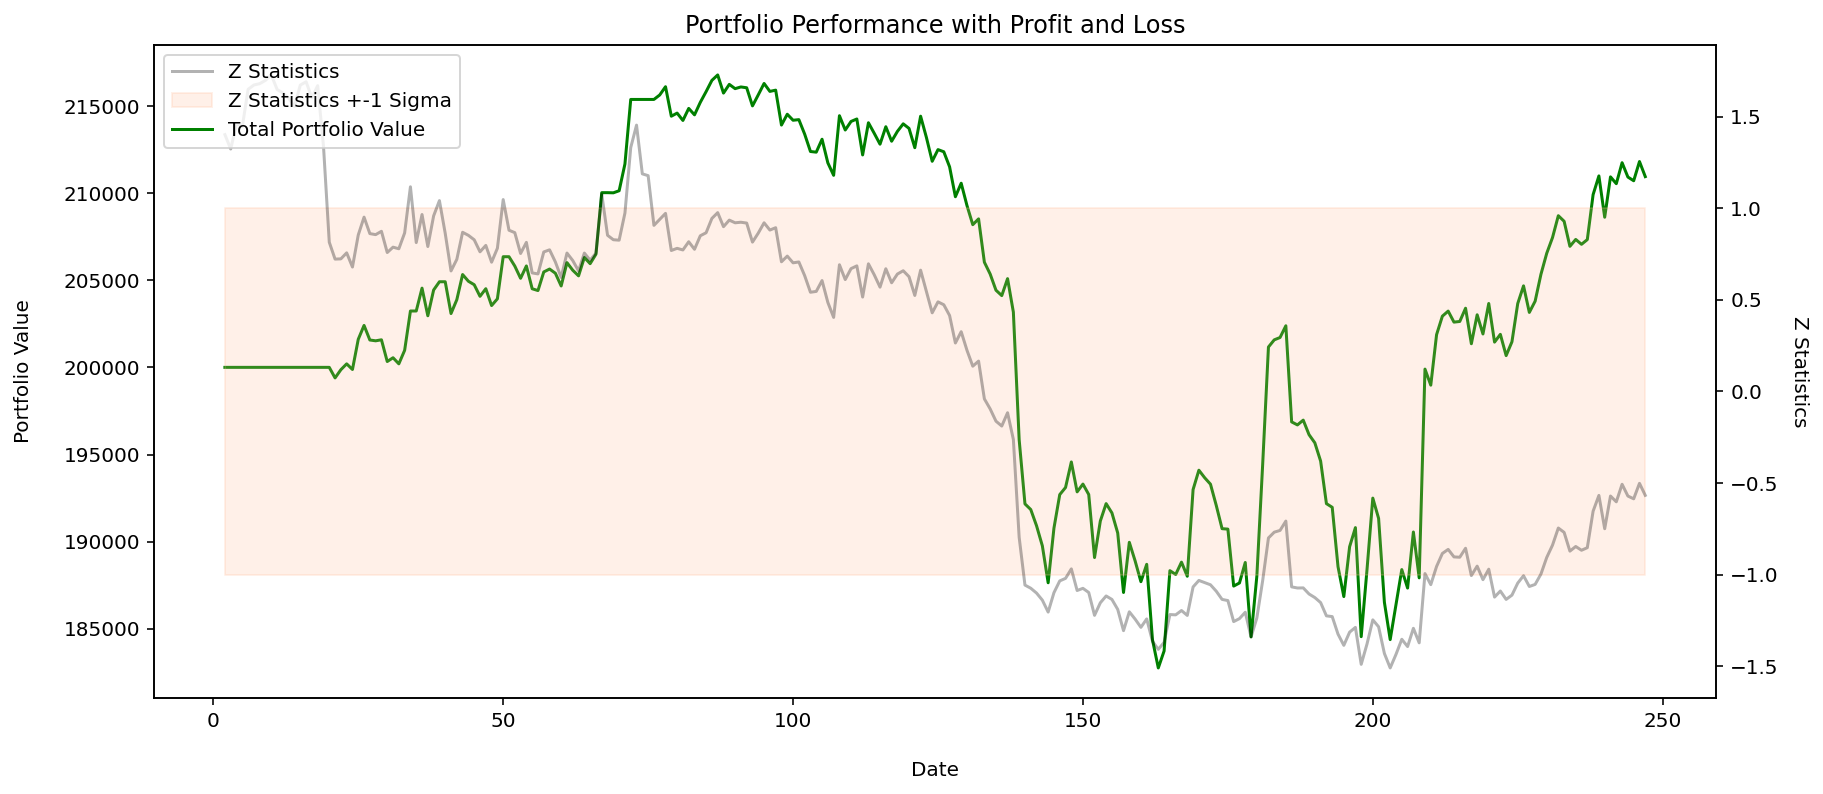

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

210941.93950600002

In [46]:
profit = final_portfolio - 2*initial_capital
profit

10941.939506000024

In [51]:
roi = (profit /(2*initial_capital))*100
roi

5.470969753000012

In [52]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [53]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 204.044%
